In [97]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from utils.ml_utils import *

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterSampler
from tqdm import tqdm

from data_prep import load_features_data



**Load the features data, these are popular trend following features used in prior literature**

In [98]:
feats = load_features_data()
feats.tail()

ret      rVol    1d_ret   1wk_ret    1m_ret  \
date       cluster                                                     
2024-03-15 15       0.052935  0.010646 -0.009848 -0.017287  0.002016   
           16       2.355712  0.010487  0.003585  0.054587  0.082955   
           17       6.049651  0.010363  0.005988  0.013662  0.008980   
           18       1.818130  0.010196 -0.001021  0.011817  0.038944   
           19       1.014050  0.010568 -0.018105 -0.010729  0.088893   

                      1Q_ret    6M_ret   12M_ret  feature_1d_ra  \
date       cluster                                                
2024-03-15 15       0.071679  0.201208  0.202884      -0.925114   
           16       0.095509  0.074083  0.173772       0.341819   
           17       0.211590  0.529950  0.663190       0.577818   
           18      -0.010944  0.054041  0.345464      -0.100130   
           19       0.143403 -0.036800 -0.004099      -1.713252   

                    feature_1wk_ra  ...  lag5_feature_MACD_short  \
date       cluster                  ...                            
2024-03-15 15            -0.726237  ...                 0.118525   
           16             2.327878  ...                 0.464299   
           17             0.589546  ...                 0.115569   
           18             0.518333  ...                -0.049638   
           19            -0.454027  ...                 0.627858   

                    lag5_feature_MACD_medium  lag5_feature_MACD_long  \
date       cluster                                                     
2024-03-15 15                       0.407592                0.856639   
           16                       0.561470                0.464375   
           17                       0.447172                0.922814   
           18                      -0.360213               -0.198844   
           19                       0.650850                0.180584   

                    lag5_feature_skew6m  lag5_feature_skew12m  \
date       cluster                                              
2024-03-15 15                  0.066425              0.395266   
           16                  0.051510              0.388949   
           17                  0.039734              0.385207   
           18                  0.021089              0.386226   
           19                 -0.006129              0.376940   

                    lag5_feature_kurt6m  lag5_feature_kurt12m  fwd_ret1d  \
date       cluster                                                         
2024-03-15 15                  2.899242              4.029588        NaN   
           16                  2.898267              4.018791        NaN   
           17                  2.909077              4.015372        NaN   
           18                  2.867876              4.029249        NaN   
           19                  2.834308              3.977828        NaN   

                    target  targetBin  
date       cluster                     
2024-03-15 15          NaN        NaN  
           16          NaN        NaN  
           17          NaN        NaN  
           18          NaN        NaN  
           19          NaN        NaN  

[5 rows x 89 columns]

count    122159.000000
mean          0.021593
std           1.174714
min         -85.683531
25%          -0.488733
50%           0.016550
75%           0.557727
max          46.648605
Name: target, dtype: float64


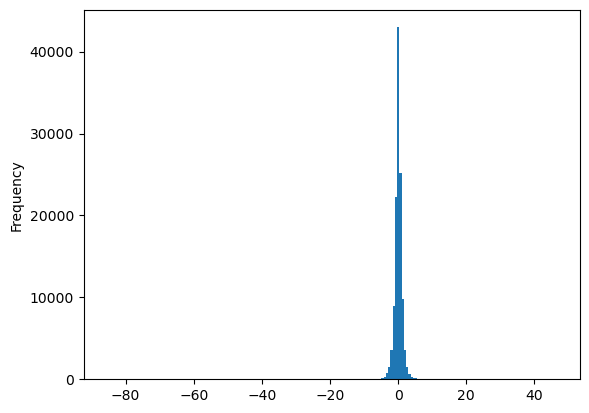

In [99]:
# distribution of tragets
feats['target'].plot(kind='hist', bins=200)
print(feats['target'].describe())

**Extract the predictive features and target, which is one day forward risk adjusted return - drop na on this subset**

In [100]:
features = [f for f in feats.columns if f.startswith("feature")]
lag_feats = [f for f in feats.columns if f.startswith("lag")]
target = ["target"]

all_feats = features + target + lag_feats
feats.dropna(subset=all_feats, inplace=True)
feats = feats[all_feats]

print("Shape of features", feats.shape)

Shape of features (117040, 79)


**Break out X and y and set up cross-validation**

In [101]:
X = feats[all_feats].copy()

baseRF = RandomForestRegressor(max_depth=5, 
                               n_estimators=1000,
                               max_features=int(1),
                               n_jobs=-3)

# simple-grid
grid = {'n_estimators': np.arange(100, 1000, 100),
        'max_depth': [3, 6, 9],
        'max_features': [int(1), 'sqrt'],
        'min_weight_fraction_leaf': np.arange(0.0, 0.05, 0.005)}

params = ParameterSampler(n_iter=25, param_distributions=grid)


**Form the training loop, here we train on 3 year expanding windows, using 90% of each split for training and 10% for tuning hyper-parameters, we then use the same model to forecast forward 3-years before re-training again.**

In [102]:
predictions = []
scores = []
for train, test in tqdm(get_cv_splits(X, split_length=252*3)):
    # break out X and y train, test
    X_train, y_train = train[features], train[target] 
    X_test, y_test = test[features], test[target]

    # hyper-param loop
    X_train2, X_val, y_train2, y_val = train_val_split(X_train, y_train)
    print(X_train2.shape, X_val.shape)

    # inner loop for parameter tuning
    gscv_scores = {'scores': [], 'grid':[]}
    for k, p in enumerate(params):
        model = RandomForestRegressor(**p)
        model.n_jobs=-1
        model.fit(X_train2, y_train2.values.reshape(y_train2.shape[0], ))
        _pred = model.predict(X_val)
        _score = mean_squared_error(y_val, _pred)
        gscv_scores['scores'].append(_score)
        gscv_scores['grid'].append(p)
        print(f'Iter: {k}: Score: {_score}')

    # now fit the best model
    best_model = pd.DataFrame(gscv_scores).sort_values(by='scores').head(1)['grid'].values[0]
    print(best_model)
    best_model = RandomForestRegressor(**best_model)
    best_model.n_jobs=-1
    best_model.fit(X_train, y_train.values.reshape(y_train.shape[0], ))
    preds = best_model.predict(X_test)

    # append the predictions
    predictions.append(pd.Series(index=y_test.index, data=preds))

    # score
    scores.append(mean_squared_error(y_test, preds))

# predictions
predictions = pd.concat(predictions).to_frame("predictions")

0it [00:00, ?it/s]

7
(13626, 13) (1500, 13)
Iter: 0: Score: 1.3356528959045066
Iter: 1: Score: 1.3401901400480514
Iter: 2: Score: 1.3371788110928007
Iter: 3: Score: 1.3389459347784523
Iter: 4: Score: 1.3367579902944304
Iter: 5: Score: 1.3376106982769962
Iter: 6: Score: 1.3373074892181627
Iter: 7: Score: 1.336285657235613
Iter: 8: Score: 1.3458355936637518
Iter: 9: Score: 1.3559949414729318
Iter: 10: Score: 1.33850237951508
Iter: 11: Score: 1.338196317999299
Iter: 12: Score: 1.3370494347640436
Iter: 13: Score: 1.3356134868759562
Iter: 14: Score: 1.3583102282146415
Iter: 15: Score: 1.3378598375565913
Iter: 16: Score: 1.3372478160806223
Iter: 17: Score: 1.3398512040463495
Iter: 18: Score: 1.3368598996490337
Iter: 19: Score: 1.3389385704744354
Iter: 20: Score: 1.3370059912740637
Iter: 21: Score: 1.3385335469102853
Iter: 22: Score: 1.337010334414161
Iter: 23: Score: 1.336751303074715
Iter: 24: Score: 1.3369021896196531
{'n_estimators': 500, 'min_weight_fraction_leaf': 0.02, 'max_features': 1, 'max_depth': 3}


1it [00:26, 26.31s/it]

(27252, 13) (3020, 13)
Iter: 0: Score: 1.443166955591281
Iter: 1: Score: 1.443135663745645
Iter: 2: Score: 1.4430257496705041
Iter: 3: Score: 1.4429357513787489
Iter: 4: Score: 1.4432797273842344
Iter: 5: Score: 1.443443784542019
Iter: 6: Score: 1.4427189572312147
Iter: 7: Score: 1.442742070266363
Iter: 8: Score: 1.4443338600791644
Iter: 9: Score: 1.4443656681716421
Iter: 10: Score: 1.4430486524153616
Iter: 11: Score: 1.4447978508455577
Iter: 12: Score: 1.44324412173748
Iter: 13: Score: 1.4429513860807277
Iter: 14: Score: 1.443007186737475
Iter: 15: Score: 1.4452556656786661
Iter: 16: Score: 1.444406881136853
Iter: 17: Score: 1.4425686320719338
Iter: 18: Score: 1.4432981902957898
Iter: 19: Score: 1.443017977227201
Iter: 20: Score: 1.4521314227695183
Iter: 21: Score: 1.4432345707117273
Iter: 22: Score: 1.4436007854720927
Iter: 23: Score: 1.4428609436771076
Iter: 24: Score: 1.4429042255360394
{'n_estimators': 200, 'min_weight_fraction_leaf': 0.035, 'max_features': 1, 'max_depth': 9}


2it [00:57, 28.93s/it]

(40860, 13) (4540, 13)
Iter: 0: Score: 1.3534552695372644
Iter: 1: Score: 1.3533123589072389
Iter: 2: Score: 1.3539029100713658
Iter: 3: Score: 1.3538795579759086
Iter: 4: Score: 1.3545620697753908
Iter: 5: Score: 1.3542759376375701
Iter: 6: Score: 1.3535185048969864
Iter: 7: Score: 1.3537306686949326
Iter: 8: Score: 1.3538955868893932
Iter: 9: Score: 1.3543412457297528
Iter: 10: Score: 1.3554144089753992
Iter: 11: Score: 1.3543863098210618
Iter: 12: Score: 1.3535907265662817
Iter: 13: Score: 1.3549703626370526
Iter: 14: Score: 1.3541242183536466
Iter: 15: Score: 1.352555075400812
Iter: 16: Score: 1.3547321669310577
Iter: 17: Score: 1.3531614514674115
Iter: 18: Score: 1.3550003457277233
Iter: 19: Score: 1.3534103799042596
Iter: 20: Score: 1.3535732581726108
Iter: 21: Score: 1.3547199359907138
Iter: 22: Score: 1.3529059557795846
Iter: 23: Score: 1.3536664394394806
Iter: 24: Score: 1.354804497228558
{'n_estimators': 900, 'min_weight_fraction_leaf': 0.0, 'max_features': 1, 'max_depth': 3}

3it [02:03, 46.01s/it]

(54468, 13) (6040, 13)
Iter: 0: Score: 1.3276127560489168
Iter: 1: Score: 1.3274575075428505
Iter: 2: Score: 1.3276104428780866
Iter: 3: Score: 1.327684261574867
Iter: 4: Score: 1.327769426188635
Iter: 5: Score: 1.3280268037204894
Iter: 6: Score: 1.3275900693331708
Iter: 7: Score: 1.3276168127333483
Iter: 8: Score: 1.3284332523135662
Iter: 9: Score: 1.3279014248976493
Iter: 10: Score: 1.3283451492879759
Iter: 11: Score: 1.3278857020642745
Iter: 12: Score: 1.3279337118591443
Iter: 13: Score: 1.3280014790891497
Iter: 14: Score: 1.328894542026481
Iter: 15: Score: 1.327578810186692
Iter: 16: Score: 1.3278220315415383
Iter: 17: Score: 1.3275189624847614
Iter: 18: Score: 1.3275546556538778
Iter: 19: Score: 1.3283380820838249
Iter: 20: Score: 1.3275948529405865
Iter: 21: Score: 1.3286998151250542
Iter: 22: Score: 1.3279834710953473
Iter: 23: Score: 1.3305215227032807
Iter: 24: Score: 1.3283020896734872
{'n_estimators': 100, 'min_weight_fraction_leaf': 0.025, 'max_features': 1, 'max_depth': 3}

4it [02:55, 48.56s/it]

(68076, 13) (7560, 13)
Iter: 0: Score: 1.3017837716660503
Iter: 1: Score: 1.3019673199113386
Iter: 2: Score: 1.301745518762805
Iter: 3: Score: 1.3018178495604156
Iter: 4: Score: 1.3016878853359068
Iter: 5: Score: 1.301682654465436
Iter: 6: Score: 1.3014745034345083
Iter: 7: Score: 1.3018977980675244
Iter: 8: Score: 1.302173135450865
Iter: 9: Score: 1.3016118750520196
Iter: 10: Score: 1.3018419661571912
Iter: 11: Score: 1.301797814807748
Iter: 12: Score: 1.3019384479764085
Iter: 13: Score: 1.3024163249273226
Iter: 14: Score: 1.3020239899320913
Iter: 15: Score: 1.3021111257437687
Iter: 16: Score: 1.301887406927072
Iter: 17: Score: 1.301564963514542
Iter: 18: Score: 1.3017604410848989
Iter: 19: Score: 1.302140636852039
Iter: 20: Score: 1.3018552215094248
Iter: 21: Score: 1.3020143951660583
Iter: 22: Score: 1.3015377499049459
Iter: 23: Score: 1.3018361623777515
Iter: 24: Score: 1.301866076355313
{'n_estimators': 900, 'min_weight_fraction_leaf': 0.01, 'max_features': 1, 'max_depth': 6}


5it [04:26, 63.87s/it]

(81684, 13) (9060, 13)
Iter: 0: Score: 1.342386628658598
Iter: 1: Score: 1.34236187586943
Iter: 2: Score: 1.3422576934813617
Iter: 3: Score: 1.342208518418052
Iter: 4: Score: 1.3424756091929484
Iter: 5: Score: 1.342137853864526
Iter: 6: Score: 1.3423660420633874
Iter: 7: Score: 1.342164810636625
Iter: 8: Score: 1.3421098621953629
Iter: 9: Score: 1.3425112490862112
Iter: 10: Score: 1.3421963792214546
Iter: 11: Score: 1.342312395368139
Iter: 12: Score: 1.3422430923158217
Iter: 13: Score: 1.3420864976795548
Iter: 14: Score: 1.3429087878098387
Iter: 15: Score: 1.3426168006437729
Iter: 16: Score: 1.342590316608547
Iter: 17: Score: 1.3423643323675474
Iter: 18: Score: 1.342638965099545
Iter: 19: Score: 1.342016135595417
Iter: 20: Score: 1.3419812424028241
Iter: 21: Score: 1.3423956338558585
Iter: 22: Score: 1.3428645104237358
Iter: 23: Score: 1.342137233210277
Iter: 24: Score: 1.3425615412225493
{'n_estimators': 100, 'min_weight_fraction_leaf': 0.01, 'max_features': 1, 'max_depth': 9}


6it [06:04, 75.28s/it]

(95292, 13) (10580, 13)
Iter: 0: Score: 1.3069945277826296
Iter: 1: Score: 1.3061359008253777
Iter: 2: Score: 1.3061043841644935
Iter: 3: Score: 1.3055894033680937
Iter: 4: Score: 1.3061673601155108
Iter: 5: Score: 1.305979426707834
Iter: 6: Score: 1.3060753734246262
Iter: 7: Score: 1.3069734227520668
Iter: 8: Score: 1.305747320467595
Iter: 9: Score: 1.3085543637231256
Iter: 10: Score: 1.3062714378667224
Iter: 11: Score: 1.3055943418043996
Iter: 12: Score: 1.3056292745348443
Iter: 13: Score: 1.3055792107164044
Iter: 14: Score: 1.3057645568053475
Iter: 15: Score: 1.3055777283662906
Iter: 16: Score: 1.3055026262752758
Iter: 17: Score: 1.3058814185812682
Iter: 18: Score: 1.305874958588814
Iter: 19: Score: 1.3055662317286598
Iter: 20: Score: 1.3060562641281575
Iter: 21: Score: 1.3056873159623796
Iter: 22: Score: 1.3056109728516085
Iter: 23: Score: 1.3083791715270918
Iter: 24: Score: 1.3055857813595724
{'n_estimators': 300, 'min_weight_fraction_leaf': 0.02, 'max_features': 'sqrt', 'max_dept

7it [08:22, 71.85s/it]


**Check distribution of the targets**

<Axes: title={'center': 'distribution of predictions'}, ylabel='Frequency'>

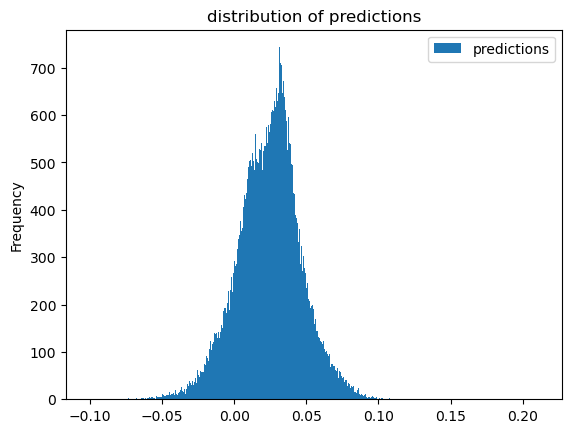

In [103]:
# we can see predictions go negative at about the 25% percentile , market mainly goes up
predictions.plot(kind='hist', bins=1000, title="distribution of predictions")

**Join in predictions with the original dataset which has the cluster returns**

In [104]:
# bring in the data
data = load_features_data()

# join in predictions
predictions = predictions.merge(data, how="left", left_index=True, right_index=True)
predictions.sort_index(inplace=True)

**On each day divide the predictions into quartiles and compute the mean return, the top quartile should be the highest predicted cluster returns**

In [111]:
predictions['signalQ'] = predictions.groupby(by='date')['predictions'].apply(lambda x: pd.qcut(x, 4, labels=False)).droplevel(0)

# shift signal back by one day
predictions['signalQ'] = predictions.groupby(by='cluster')['signalQ'].shift(1)
rets = predictions.groupby(by=['date', 'signalQ'])['1d_ret'].mean().unstack()

**Group by signalQ shifted back by one day and then compute the average return, unstack to get time series of mean cluster returns by signal quartile. Compute portfolio returns with the utils function**

In [116]:
rets = predictions.groupby(by=['date', 'signalQ'])['1d_ret'].mean().unstack()
rets.rename(columns={col: f'Q_{col}' for col in rets.columns}, inplace=True)

get_returns_breakout(rets)

,Annual_Return,Annual_Volatility,DD,MDD,Sharpe,Sortino,Calmar,ppct_postive_rets
Q_0.0,0.069851,0.198497,0.139595,-0.660061,0.439405,0.624812,0.105824,0.532429
Q_1.0,0.008674,0.19951,0.142891,-0.579064,0.143155,0.199878,0.014979,0.527909
Q_2.0,0.046314,0.194926,0.140645,-0.597813,0.330084,0.457478,0.077472,0.532036
Q_3.0,0.074975,0.198824,0.143645,-0.456603,0.463468,0.6415,0.164201,0.537146
Q_4.0,0.048314,0.195842,0.141057,-0.533761,0.339214,0.470962,0.090516,0.535574


<Axes: title={'center': 'Cumulative Strategy Returns'}, xlabel='date'>

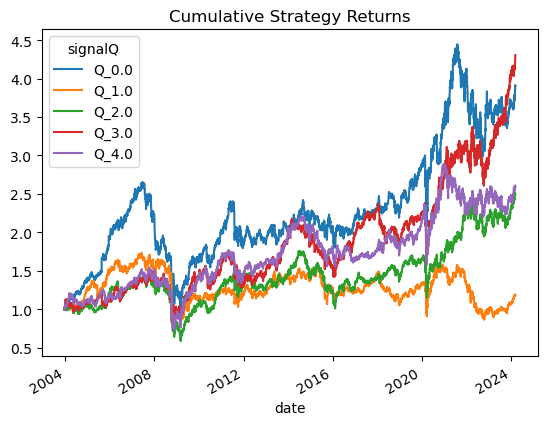

In [117]:
# plot the returns
(1 + rets).cumprod().plot(title="Cumulative Strategy Returns")